In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from v1dd_public import ARTIFACT_DIR

In [3]:
csv_tag = "_240610"

def load_and_preprocess(file_name, mouse_id):
    # remove duplicate neurons
    df = pd.read_csv(ARTIFACT_DIR / file_name, dtype={'column': str, 'volume': str, '2p3p': str, 'valid_not_duplicate': bool}, low_memory=False)
    df.insert(1, 'mouse_id', mouse_id, True)
    
    # remove all cells in the column 1 that are 2P (keeps the 3P)
    df = df[~((df["column"] == '1') & (df["2p3p"] == '2'))]
    df = df[df["valid_not_duplicate"]]
    return df

# Load and preprocess the data
slc2 = load_and_preprocess(f'slc2_all_stim_metrics{csv_tag}.csv', "slc2")
slc4 = load_and_preprocess(f'slc4_all_stim_metrics{csv_tag}.csv', "slc4")
slc5 = load_and_preprocess(f'slc5_all_stim_metrics{csv_tag}.csv', "slc5")
teto1 = load_and_preprocess(f'teto1_all_stim_metrics{csv_tag}.csv', "teto1")
cell_info = pd.concat([slc2, slc4, slc5, teto1], ignore_index=True)

In [4]:
colors = [
    '#FF5733',  # Red
    '#33FF57',  # Green
    '#3357FF',  # Blue
    '#F1C40F',  # Yellow
    '#9B59B6',  # Purple
    'cyan',     # Cyan, named color
    'magenta',  # Magenta, named color
    '#FFC300',  # Gold
    '#DAF7A6',  # Light Green
    '#581845',  # Dark Purple
    '#34495E',  # Asphalt
    '#16A085',  # Green Sea
    '#E74C3C',  # Red Orange
    '#2980B9',  # Belize Hole Blue
    'chocolate' # Chocolate, named color
]

color1 = '#f7fcf0'
color2 = '#e0f3db'
color3 = '#ccebc5'
color4 = '#a8ddb5'
color5 = '#7bccc4'
color6 = '#4eb3d3'
color7 = '#2b8cbe'
color8 = '#08589e'

box_colors = [color8, color7, color6, color5, color5, color4, color4, color3, color3, color2, color2, color1, color1]

mouse_colors = {'slc2': "#66CCEE", 'slc4': "#228833", 'slc5': '#CCBB44', 'teto1': '#EE6677'}
mice = ['slc2', 'slc4', 'slc5', 'teto1']
mouse_ids = ["M409828", "M416296", "M427836", "M438833"]
z_groups_high_to_low = [[650, 675, 700, 725], [575, 600, 625], [500, 525, 550], [482, 498, 514], [434, 450, 466], \
    [386, 402, 418], [338, 354, 370], [290, 306, 322], [242, 258, 274], [194, 210, 226], [146, 162, 178], [98, 114, 130], [50, 66, 82]]

In [7]:
def make_z_data(stimuli, feature_titles, z_groups_high_to_low, mice, cell_info, plot_type):
    fontsize = 12
    plt.figure(figsize=(21, 10))

    for i, stimulus in enumerate(stimuli):
        ax = plt.subplot(1, 7, i + 1)

        data_for_stimulus = []
        mouse_data_for_stimulus = []

        for group_idx, z_group in enumerate(z_groups_high_to_low):
            every_z_data = []

            for z in z_group:
                plane = (cell_info['z'] == z)
                z_cell_info = cell_info[plane][stimulus]
                every_z_data.extend(z_cell_info.dropna().to_numpy())
            data_for_stimulus.append(every_z_data)

            mouse_data_for_current_z_group = []
            for mouse in mice:
                every_z_mouse_data = []
                for z in z_group:
                    plane = (cell_info['z']==z) & (cell_info['mouse_id'] == mouse)
                    every_z_mouse_data.extend(cell_info[plane][stimulus].dropna().to_numpy())
                mouse_data_for_current_z_group.append(np.median(every_z_mouse_data))
            mouse_data_for_stimulus.append(mouse_data_for_current_z_group)
            
        if plot_type == "violin":
            violinplot_elements = plt.violinplot(data_for_stimulus, vert=False, showmedians=True)
            for pc, color in zip(violinplot_elements['bodies'], box_colors):
                pc.set_facecolor(color)
                pc.set_edgecolor('black')
        elif plot_type == "box":
            flierprops = dict(marker='o', markerfacecolor='white', markersize=0, linestyle='none')
            boxplot_elements = plt.boxplot(data_for_stimulus, vert=False, flierprops=flierprops, patch_artist=True)
            for box, color in zip(boxplot_elements['boxes'], box_colors):
                box.set_facecolor(color)
                box.set_edgecolor('black')

        for idx, group_data in enumerate(mouse_data_for_stimulus, 1):
            for mouse_idx, mouse_data in enumerate(group_data):
                if mouse_data:
                    mouse = mice[mouse_idx]
                    color = mouse_colors.get(mouse, "black")
                    plt.scatter(mouse_data, idx, color=color, zorder=3)
        if i == 0:
            y_tick_labels = [int(np.mean(group)) for group in z_groups_high_to_low]
            plt.yticks(np.arange(1, len(z_groups_high_to_low) + 1), y_tick_labels, fontsize=fontsize)
            plt.ylabel("Depth (µm)", fontsize=fontsize)
            
        elif i == len(stimuli) - 1:
            n_labels = [f"n={len(group)}" for group in data_for_stimulus]
            print(len(data_for_stimulus))
            ax.set_yticks(np.arange(1, len(z_groups_high_to_low) + 1))
            ax.set_yticklabels(n_labels, fontsize=fontsize)
            ax.yaxis.tick_right()
        else:
            plt.yticks([]) 

        plt.title(feature_titles[i])
        plt.xlabel("Fraction", fontsize=fontsize)
        plt.xlim([-0.05, 1.1])

    return data_for_stimulus, mouse_data_for_stimulus

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


13


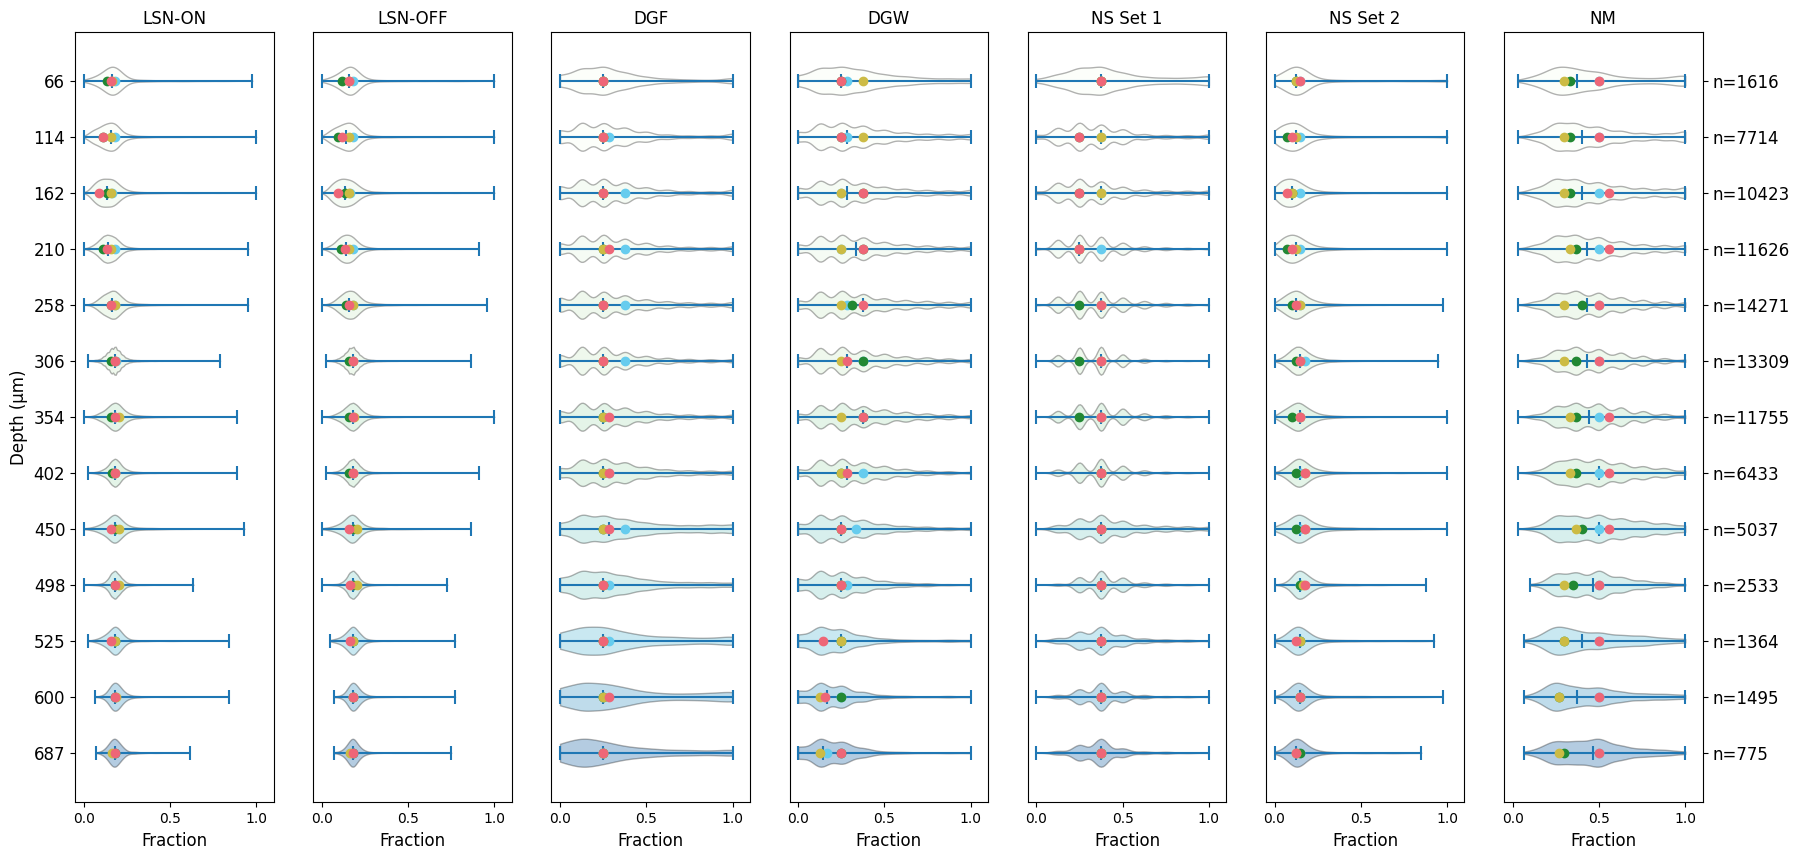

In [9]:
stimuli = ['frac_res_to_on',
        'frac_res_to_off',
        'frac_resp_dgf',
        'frac_resp_dgw',
        'frac_res_to_ns118',
        'frac_res_to_ns12',
        'frac_resp_nm'
       ]
feature_titles = ['LSN-ON', 'LSN-OFF', 'DGF', 'DGW', 'NS Set 1', 'NS Set 2', 'NM']

data_for_stimulus, mouse_data_for_stimulus = make_z_data(stimuli, feature_titles, \
       z_groups_high_to_low, mice, cell_info, plot_type="violin")
plt.savefig("/home/naomi/Desktop/figures/v1dd_plots/supp2_mean_frac_violin.eps", format='eps', dpi=1000)